# Instructions: 
##### To just produce final graph(s) as seen in the paper, run cells in "Section 1: Setup" and "Section 2: Final Graph(s)" section only, ignore the "Section 3: Simulations "
##### To run the simulations and produce your own data, run the whole notebook

### Section 1: Setup

In [14]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections
from scipy.special import gamma, factorial
from scipy import stats

###########################################

plt.style.use('seaborn-talk')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10

##############################################
def migration_matrix_2d(length, migration_rate):
    result=[ [0]*length**2 for i in range(length**2)]
    for i in range(length**2):
        for j in range(length**2):
            #print(i)
            #left edge cases
            if i == 0:
                result[i][i+1]= migration_rate
                result[i][length]=migration_rate
            elif i==(length*(length-1)):
                result[i][i-length]= migration_rate
                result[i][i+1]=migration_rate
            elif i%length==0 :
                result[i][i-length]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i+length]=migration_rate
                
            #right edge cases 
            elif i==length-1:
                result[i][i-1]=migration_rate
                result[i][i+length]=migration_rate
            elif i==(length**2-1):
                result[i][i-length]= migration_rate
                result[i][i-1]=migration_rate
            elif (i+1)%length==0 :
                result[i][i-length]= migration_rate
                result[i][i-1]=migration_rate
                result[i][i+length]=migration_rate
                
            
            #top and bottom edge cases
            elif 0< i <length-1:
                result[i][i-1]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i+length]=migration_rate
            elif (length)*(length-1) < i < length**2-1:
                result[i][i-1]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i-length]=migration_rate
                
            #inner nodes
            else:
                result[i][i-1]= migration_rate
                result[i][i+1]=migration_rate
                result[i][i-length]=migration_rate
                result[i][i+length]=migration_rate
                
                
                
                
                
            
    return result

##############################################################
Deme_density = 10
L = 900 #the number of demes 
deme_sample_size = Deme_density #deme sample size = 40
trials = 50 #number of trials
m=0.005
total_sample_size = int(L * deme_sample_size) # total sample size
matrix = migration_matrix_2d(int(np.sqrt(L)), m/4)


population_configurations = L * [msprime.PopulationConfiguration(deme_sample_size)]

print("we want 1 <<< m*deme_density ")
print("1 <<< ",m*Deme_density )

we want 1 <<< m*deme_density 
1 <<<  0.05


### Section 2: Simulations 

In [15]:
afs2 = []
for i in range(50):
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix,record_provenance=False);


    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False);
    
    afs2.append(afs1);

    
    #print("iteration",i);
    #unhash above line if you want to track progress of simulation
    
afs = np.mean(afs2, 0)  

In [16]:
def smooth(x, threshold=100, rescale=2):
    return [np.mean(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]

In [17]:
def smooth_sem(x, threshold, rescale):
        return [stats.sem(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]


In [18]:
m_1=m/2
m_2=m/2
m_t=m_1+m_2
Effective_pop = (L)/(m_t)
print("The effective population size via Maruyama equation is: ", Effective_pop)
real_pop = L*Deme_density
print("The real population size is", real_pop)

# Since we're using branch lengths, the mutation rate is 1
Theta_eff = 4 * Effective_pop
Theta_real = 4 * real_pop




The effective population size via Maruyama equation is:  180000.0
The real population size is 9000


In [19]:
std_data=np.std(smooth(afs[1:], threshold=1000, rescale=200))
error=std_data/np.sqrt(len(smooth(afs[1:], threshold=1000, rescale=200)))

In [20]:
transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size
print(transition_freq)

0.0011111111111111111


In [21]:
thresh=1000
scale=200

In [22]:
err=np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))

C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'SNP Count')

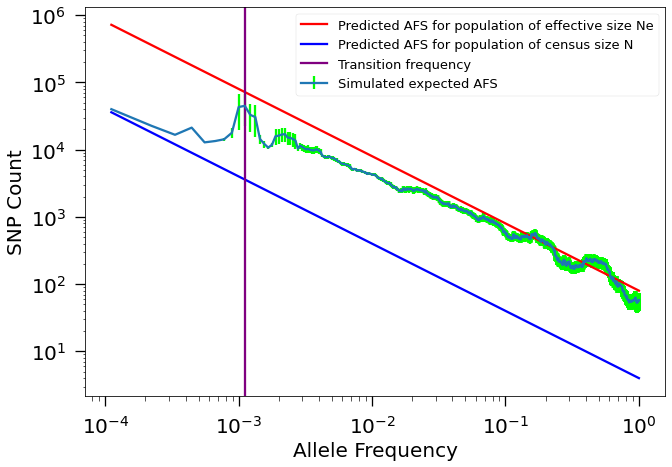

In [23]:
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_eff / np.arange(1,total_sample_size+1), color="red")
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_real / np.arange(1,total_sample_size+1), color="blue")
#plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1),smooth(afs[1:], threshold=1000, rescale=200), color="green") 
plt.axvline(transition_freq,color='purple')
#plt.axvline(0.2,color="orange")

plt.errorbar(np.arange(1, total_sample_size+1)/total_sample_size,smooth(afs[1:], threshold=thresh, rescale=scale), yerr=err, ecolor="lime")
plt.legend(["Predicted AFS for population of effective size Ne", "Predicted AFS for population of census size N" , 'Transition frequency', 'Simulated expected AFS'], loc ="upper right")
plt.xlabel("Allele Frequency")
plt.ylabel("SNP Count")


##### Producing Bi-directional migration prediction

In [24]:
a=[]
y=np.arange(1,total_sample_size)/total_sample_size
for i in range (len(y)):
    if np.min(y)<=y[i]<=transition_freq:
        a.append(y[i])
b=np.array(a)
print(b)
len(b)

[0.00011111 0.00022222 0.00033333 0.00044444 0.00055556 0.00066667
 0.00077778 0.00088889 0.001      0.00111111]


10

In [25]:
x=np.array(b)*1/(np.max(b))
print(x)
len(x)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


10

In [26]:
N=total_sample_size*transition_freq
u=m ## Migration rate taken as the effective mutation rate of the mutant A1 to the wild type A2
v=0 ## Mutation rate of wild type A2 to mutant A1
Beta_1=2*N*u
Beta_2=2*N*v
#print(Beta_1)
#print(Beta_2)
print(Beta_1)

0.1


In [27]:
numerator=scipy.special.gamma(2*Beta_1+2*Beta_2)
denominator=scipy.special.gamma(2*Beta_1)*scipy.special.gamma(2*Beta_2)

gamma_coefficient=1

In [28]:
frequency_value=(x**(2*Beta_2-1))*((1-x)**(2*Beta_1-1))

## Setting up the frequency/x part of the equation
print(frequency_value)

[10.87942625  5.97720312  4.43404721  3.76200188  3.48220225  3.4689717
  3.74287184  4.5298729   7.01063716         inf]


<ipython-input-28-0f5209aa8ca7>:1: RuntimeWarning: divide by zero encountered in power
  frequency_value=(x**(2*Beta_2-1))*((1-x)**(2*Beta_1-1))


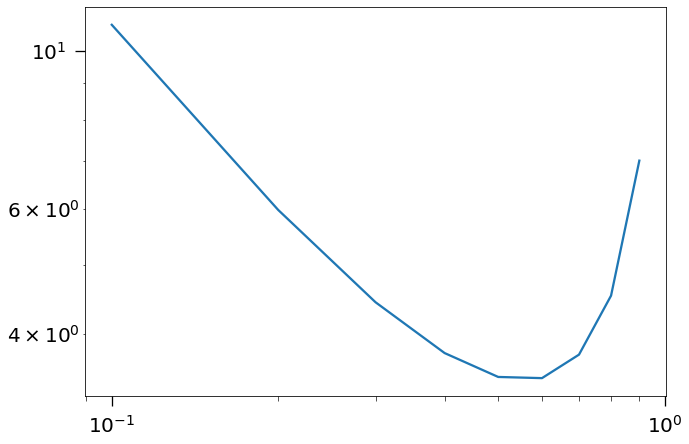

In [29]:
Effective_dist=gamma_coefficient*frequency_value
#max(Effective_dist)
plt.loglog(x,Effective_dist)

In [30]:
e=np.linspace(1/total_sample_size,transition_freq,len(x))
print(e)
len(e)

[0.00011111 0.00022222 0.00033333 0.00044444 0.00055556 0.00066667
 0.00077778 0.00088889 0.001      0.00111111]


10

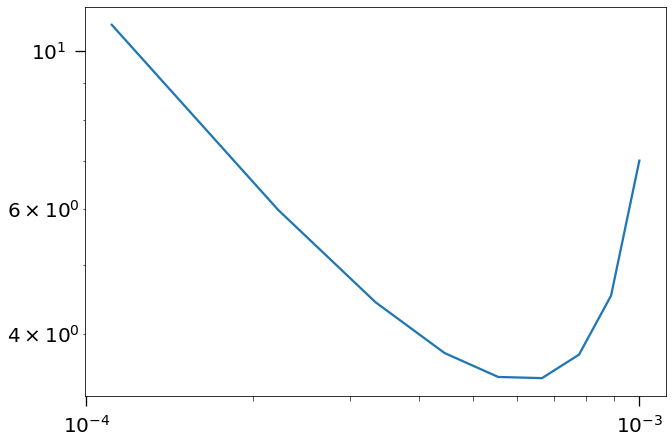

In [31]:
Effective_dist=gamma_coefficient*frequency_value
#max(Effective_dist)
plt.loglog(e,Effective_dist)

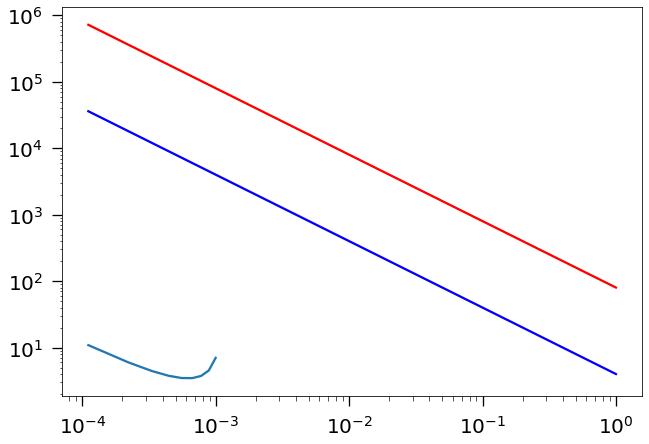

In [32]:
plt.loglog(np.arange(1,total_sample_size)/total_sample_size, Theta_eff / np.arange(1,total_sample_size), color="red")
plt.loglog(np.arange(1,total_sample_size)/total_sample_size, Theta_real / np.arange(1,total_sample_size), color="blue")
plt.loglog(e,Effective_dist)


In [33]:
eff_data=Theta_real / np.arange(1,total_sample_size)
pre_factor=eff_data[0]/Effective_dist[0]

In [34]:
AF_xpoints = np.arange(1,total_sample_size+1)/(total_sample_size)
np.savetxt('2D_AF_xpoints_mrholess.csv', AF_xpoints, delimiter=',')


Maruyama_effective_ydata = Theta_eff / np.arange(1,total_sample_size+1)
np.savetxt('2D_Maruyama_effective_ydata_mrholess.csv', Maruyama_effective_ydata, delimiter=',')

Maruyama_census_ydata = Theta_real / np.arange(1,total_sample_size+1)
np.savetxt('2D_Maruyama_census_ydata_mrholess.csv', Maruyama_census_ydata, delimiter=',')

Simulated_data = smooth(afs[1:], threshold=thresh, rescale=scale)
np.savetxt('2D_Simulated_data_mrholess.csv', Simulated_data , delimiter=',')

error_data = np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))
np.savetxt('2D_Simulated_data_mrholess_error.csv', error_data , delimiter=',')

transition_frequency=max(Deme_density,(m*Deme_density**2))/total_sample_size


bi_directional_prediction = pre_factor*Effective_dist
np.savetxt('2D_bi_directional_prediction_mrholess.csv', bi_directional_prediction , delimiter=',')


scaled_x_bidirection_points=e
np.savetxt('2D_scaled_x_bidirection_points_mrholess.csv', scaled_x_bidirection_points , delimiter=',')


C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Section 3: Final Graph(s)

In [35]:
AF_xpoints_read=np.array(pd.read_csv('2D_AF_xpoints_mrholess.csv'))

Maruyama_effective_ydata_read= np.array(pd.read_csv('2D_Maruyama_effective_ydata_mrholess.csv'))

Maruyama_census_ydata_read=np.array(pd.read_csv('2D_Maruyama_census_ydata_mrholess.csv'))

Simulated_data_read = np.array(pd.read_csv('2D_Simulated_data_mrholess.csv'))

error_data_read= np.array(pd.read_csv('2D_Simulated_data_mrholess_error.csv'))


bi_directional_prediction_read=np.array(pd.read_csv('2D_bi_directional_prediction_mrholess.csv'))

scaled_x_bidirection_points_read=np.array(pd.read_csv('2D_scaled_x_bidirection_points_mrholess.csv'))


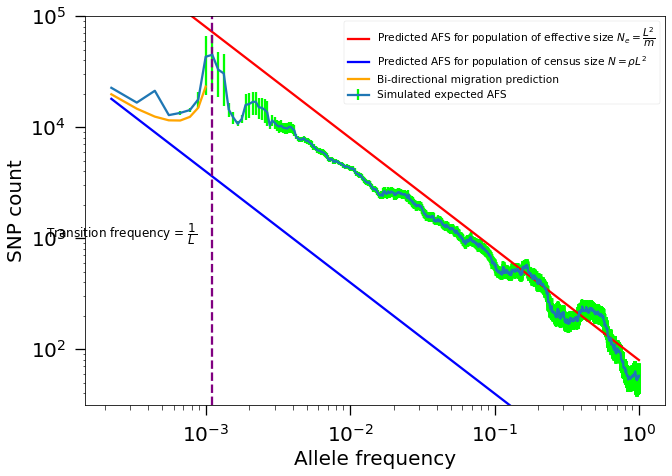

In [36]:
transition_frequency=max(Deme_density,(m*Deme_density**2))/total_sample_size
err=error_data_read.flatten()
plt.loglog(AF_xpoints_read, Maruyama_effective_ydata_read, color="red", label =r"Predicted AFS for population of effective size $N_e=\dfrac{L^2}{m}$") 
plt.loglog(AF_xpoints_read, Maruyama_census_ydata_read, color="blue", label =r"Predicted AFS for population of census size $ N=\rho L^2 $" )
#plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1), smooth(afs[1:], threshold=1000, rescale=200), color="green") 
plt.axvline(transition_frequency,color='purple', linestyle = '--')
plt.text(0.000078,1000,r"Transition frequency = $\dfrac{1}{L}$",fontsize='12')
plt.loglog(scaled_x_bidirection_points_read ,bi_directional_prediction_read,"orange", label ='Bi-directional migration prediction' )
plt.errorbar(AF_xpoints_read,Simulated_data_read, yerr=err, ecolor="lime", label = "Simulated expected AFS")
#plt.axvline(0.25)
plt.xlabel("Allele frequency")
plt.ylabel('SNP count')
#plt.legend([r"Predicted AFS for population of effective size $N_e=\frac{L^2}{m}$", r"Predicted AFS for population of census size $ N=\rho L^2 $", r'Transition frequency $= \frac{1}{L}$', "W-F fit","Simulated expected AFS" ], loc ="upper right")
plt.legend(prop={"size":10.5},loc="upper right")
plt.ylim(10**1.5, 10**5)
plt.savefig("2D_afs2.pdf")